In [1]:
import collections
import json
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from mab import algs


class ONN(nn.Module):
    def __init__(self, features_size, max_num_hidden_layers, qtd_neuron_per_hidden_layer, n_classes, batch_size=1,
                 b=0.99, n=0.01, s=0.2, use_cuda=False):
        super(ONN, self).__init__()

        if torch.cuda.is_available() and use_cuda:
            print("Using CUDA :]")

        self.device = torch.device(
            "cuda:0" if torch.cuda.is_available() and use_cuda else "cpu")

        self.features_size = features_size
        self.max_num_hidden_layers = max_num_hidden_layers
        self.qtd_neuron_per_hidden_layer = qtd_neuron_per_hidden_layer
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.b = Parameter(torch.tensor(
            b), requires_grad=False).to(self.device)
        self.n = Parameter(torch.tensor(
            n), requires_grad=False).to(self.device)
        self.s = Parameter(torch.tensor(
            s), requires_grad=False).to(self.device)

        self.hidden_layers = []
        self.output_layers = []

        self.hidden_layers.append(
            nn.Linear(features_size, qtd_neuron_per_hidden_layer))

        for i in range(max_num_hidden_layers - 1):
            self.hidden_layers.append(
                nn.Linear(qtd_neuron_per_hidden_layer, qtd_neuron_per_hidden_layer))

        for i in range(max_num_hidden_layers):
            self.output_layers.append(
                nn.Linear(qtd_neuron_per_hidden_layer, n_classes))

        self.hidden_layers = nn.ModuleList(self.hidden_layers).to(self.device)
        self.output_layers = nn.ModuleList(self.output_layers).to(self.device)

        self.alpha = Parameter(torch.Tensor(self.max_num_hidden_layers).fill_(1 / (self.max_num_hidden_layers + 1)),
                               requires_grad=False).to(
            self.device)

        self.loss_array = []
        self.tp=0.1
        self.tn=0.1
        self.fp=0.1
        self.fn=0.1
        self.bal_acc = 0
        self.sen = 0
        self.spec = 0
        
        self.protected_pos = 0.1
        self.protected_neg = 0.1
        self.non_protected_pos = 0.1
        self.non_protected_neg = 0.1
        self.stp_score=0
        
        self.tp_protected = 0.1
        self.fn_protected = 0.1
        self.tp_non_protected = 0.1
        self.fn_non_protected = 0.1
        self.eqop_score=0

    def zero_grad(self):
        for i in range(self.max_num_hidden_layers):
            self.output_layers[i].weight.grad.data.fill_(0)
            self.output_layers[i].bias.grad.data.fill_(0)
            self.hidden_layers[i].weight.grad.data.fill_(0)
            self.hidden_layers[i].bias.grad.data.fill_(0)

    def update_weights(self, X, Y, weight, show_loss):
        Y = torch.from_numpy(Y).to(self.device)
        prediction_1 = self.predict_1(X)
        predictions_per_layer = self.forward(X)
        
        
        self.update_eval_metrics(prediction_1,Y)
        self.update_stp_score(prediction_1,X)
        self.update_eqop_score(prediction_1,X,Y)
        
        losses_per_layer = []

        for out in predictions_per_layer:
            criterion = nn.CrossEntropyLoss().to(self.device)
            loss = criterion(out.view(self.batch_size, self.n_classes), Y.view(
                self.batch_size).long())
            losses_per_layer.append(loss*weight)

        w = [None] * len(losses_per_layer)
        b = [None] * len(losses_per_layer)
        
        with torch.no_grad():     #Context-manager that disabled gradient calculation

          for i in range(len(losses_per_layer)):
              losses_per_layer[i].backward(retain_graph=True)
              self.output_layers[i].weight.data -= self.n * \
                                                   self.alpha[i] * self.output_layers[i].weight.grad.data
              self.output_layers[i].bias.data -= self.n * \
                                                 self.alpha[i] * self.output_layers[i].bias.grad.data

              for j in range(i + 1):
                  if w[j] is None:
                      w[j] = self.alpha[i] * self.hidden_layers[j].weight.grad.data
                      b[j] = self.alpha[i] * self.hidden_layers[j].bias.grad.data
                  else:
                      w[j] += self.alpha[i] * self.hidden_layers[j].weight.grad.data
                      b[j] += self.alpha[i] * self.hidden_layers[j].bias.grad.data

              self.zero_grad()

          for i in range(len(losses_per_layer)):
              self.hidden_layers[i].weight.data -= self.n * w[i]
              self.hidden_layers[i].bias.data -= self.n * b[i]

          for i in range(len(losses_per_layer)):
              self.alpha[i] *= torch.pow(self.b, losses_per_layer[i])
              self.alpha[i] = torch.max(
                  self.alpha[i], self.s / self.max_num_hidden_layers)

        z_t = torch.sum(self.alpha)

        self.alpha = Parameter(
            self.alpha / z_t, requires_grad=False).to(self.device)

        if show_loss:
            
            real_output = torch.sum(torch.mul(
                self.alpha.view(self.max_num_hidden_layers, 1).repeat(1, self.batch_size).view(
                    self.max_num_hidden_layers, self.batch_size, 1), predictions_per_layer), 0)
            criterion = nn.CrossEntropyLoss().to(self.device)
            loss = criterion(real_output.view(self.batch_size, self.n_classes), Y.view(self.batch_size).long())
            self.loss_array.append(loss)
            
            if (len(self.loss_array) % 1000) == 0:
                #print("WARNING: Set 'show_loss' to 'False' when not debugging. "
                #      "It will deteriorate the fitting performance.")
                loss = torch.Tensor(self.loss_array).mean().cpu().numpy()
                #print("Alpha:" + str(self.alpha.data.cpu().numpy()))
                print("Training Loss: " + str(loss))
                print("Balanced accuracy: " + str(self.bal_acc))
                print("Sensitivity: " + str(self.sen))
                print("Specificity: " + str(self.spec))
                print("Stp score: " + str(self.stp_score))
                print("Eqop score: " + str(self.eqop_score))
                self.loss_array.clear()

    def forward(self, X):
        hidden_connections = []

        X = torch.from_numpy(X).float().to(self.device)

        x = F.relu(self.hidden_layers[0](X))
        hidden_connections.append(x)

        for i in range(1, self.max_num_hidden_layers):
            hidden_connections.append(
                F.relu(self.hidden_layers[i](hidden_connections[i - 1])))

        output_class = []

        for i in range(self.max_num_hidden_layers):
            output_class.append(self.output_layers[i](hidden_connections[i]))

        pred_per_layer = torch.stack(output_class)

        return pred_per_layer

    def validate_input_X(self, data):
        
        if len(data.shape) != 2:
            raise Exception(
                "Wrong dimension for this X data. It should have only two dimensions.")

    def validate_input_Y(self, data):
        if len(data.shape) != 1:
            raise Exception(
                "Wrong dimension for this Y data. It should have only one dimensions.")

    def partial_fit_(self, X_data, Y_data, weight, show_loss=True):
        
        self.validate_input_X(X_data)
        self.validate_input_Y(Y_data)
        self.update_weights(X_data, Y_data, weight, show_loss)

    def partial_fit(self, X_data, Y_data, weight, show_loss=True):
        
        self.partial_fit_(X_data, Y_data, weight, show_loss)

    def update_eval_metrics(self,prediction_1,Y):
        if prediction_1==1 and Y==1:
            self.tp+=1
        elif prediction_1==1 and Y==0:
            self.fp+=1
        elif prediction_1==0 and Y==1:
            self.fn+=1
        else:
            self.tn+=1
        
        self.sen = self.tp/(self.tp + self.fn)
        self.spec= self.tn/(self.tn + self.fp)
        self.bal_acc = (self.sen + self.spec)/2
            
    def update_stp_score(self,prediction_1,X):
        if X[0][sa_index] == p_Group:
            if prediction_1 == 1:
                self.protected_pos += 1.
            else:
                self.protected_neg += 1.
        else:
            if prediction_1 == 1:
                self.non_protected_pos += 1.
            else:
                self.non_protected_neg += 1.
            
        C_prot = (self.protected_pos) / (self.protected_pos + self.protected_neg)
        C_non_prot = (self.non_protected_pos) / (self.non_protected_pos + self.non_protected_neg)

        self.stp_score = C_non_prot - C_prot
    
    def update_eqop_score(self,prediction_1,X,Y):
        if X[0][sa_index] == p_Group:
            if prediction_1==1 and Y==1:
                self.tp_protected += 1.
            elif prediction_1==0 and Y==1:
                self.fn_protected += 1.
        else:
            if prediction_1==1 and Y==1:
                self.tp_non_protected += 1.
            elif prediction_1==0 and Y==1:
                self.fn_non_protected += 1.
            
        tpr_protected = self.tp_protected / (self.tp_protected + self.fn_protected)
        tpr_non_protected = self.tp_non_protected / (self.tp_non_protected + self.fn_non_protected)
        self.eqop_score = tpr_non_protected - tpr_protected
    
    def predict_1(self, X_data):
        self.validate_input_X(X_data)
        return torch.argmax(torch.sum(torch.mul(
            self.alpha.view(self.max_num_hidden_layers, 1).repeat(1, 1).view(
                self.max_num_hidden_layers, len(X_data), 1), self.forward(X_data)), 0), dim=1).cpu().numpy()
    def predict_(self, X_data):
        self.validate_input_X(X_data)
        return torch.argmax(torch.sum(torch.mul(
            self.alpha.view(self.max_num_hidden_layers, 1).repeat(1, len(X_data)).view(
                self.max_num_hidden_layers, len(X_data), 1), self.forward(X_data)), 0), dim=1).cpu().numpy()

    def predict(self, X_data):
        pred = self.predict_(X_data)
        return pred

    def export_params_to_json(self):
        state_dict = self.state_dict()
        params_gp = {}
        for key, tensor in state_dict.items():
            params_gp[key] = tensor.cpu().numpy().tolist()

        return json.dumps(params_gp)

    def load_params_from_json(self, json_data):
        params = json.loads(json_data)
        o_dict = collections.OrderedDict()
        for key, tensor in params.items():
            o_dict[key] = torch.tensor(tensor).to(self.device)
        self.load_state_dict(o_dict)


class ONN_THS(ONN):
    def __init__(self, features_size, max_num_hidden_layers, qtd_neuron_per_hidden_layer, n_classes, b=0.99, n=0.01,
                 s=0.2, e=[0.5, 0.35, 0.2, 0.1, 0.05], use_cuda=False):
        super().__init__(features_size, max_num_hidden_layers, qtd_neuron_per_hidden_layer, n_classes, b=b, n=n, s=s,
                         use_cuda=use_cuda)
        self.e = Parameter(torch.tensor(e), requires_grad=False)
        self.arms_values = Parameter(
            torch.arange(n_classes), requires_grad=False)
        self.explorations_mab = []

        for i in range(n_classes):
            self.explorations_mab.append(algs.ThompsomSampling(len(e)))

    def partial_fit(self, X_data, Y_data, exp_factor, show_loss=True):
        self.partial_fit_(X_data, Y_data, show_loss)
        self.explorations_mab[Y_data[0]].reward(exp_factor)

    def predict(self, X_data):
        pred = self.predict_(X_data)[0]
        exp_factor = self.explorations_mab[pred].select()[0]
        if np.random.uniform() < self.e[exp_factor]:
            removed_arms = self.arms_values.clone().numpy().tolist()
            removed_arms.remove(pred)
            return random.choice(removed_arms), exp_factor

        return pred, exp_factor


In [2]:
from sklearn.datasets import make_classification, make_circles
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from imblearn.datasets import make_imbalance
import numpy as np

In [3]:
# import urllib2
import os, sys
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn import feature_extraction
from sklearn import preprocessing
from random import seed, shuffle

# import utils as ut

SEED = 1234
seed(SEED)
np.random.seed(SEED)


def load_adult():
    FEATURES_CLASSIFICATION = ["age","workclass","fnlwgt","education","education-num","marital-status","occupation",
                               "relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country"] #features to be used for classification
    CONT_VARIABLES = ["age","fnlwgt","education-num","capital-gain","capital-loss","hours-per-week"] # continuous features, will need to be handled separately from categorical features, categorical features will be encoded using one-hot
    CLASS_FEATURE = "y" # the decision variable
    SENSITIVE_ATTRS = ["sex"]
    
    COMPAS_INPUT_FILE = "./datasets/adult2.csv"

    # load the data and get some stats
    df = pd.read_csv(COMPAS_INPUT_FILE)
    df.dropna()
    # convert to np arra
    data = df.to_dict('list')

    for k in data.keys():
        data[k] = np.array(data[k])

    """ Feature normalization and one hot encoding """
    # convert class label 0 to -1
    y = data[CLASS_FEATURE]
    y[y==0] = -1
    X = np.array([]).reshape(len(y), 0) # empty array with num rows same as num examples, will hstack the features to it
    x_control = defaultdict(list)
    
    feature_names = []
    for attr in FEATURES_CLASSIFICATION:
        vals = data[attr]
        if attr in CONT_VARIABLES:
            vals = [float(v) for v in vals]
            vals = preprocessing.scale(vals) # 0 mean and 1 variance
            vals = np.reshape(vals, (len(y), -1)) # convert from 1-d arr to a 2-d arr with one col
        
        else: # for binary categorical variables, the label binarizer uses just one var instead of two
            lb = preprocessing.LabelBinarizer()   #LabelEncoder() # Label Encoder
            lb.fit(vals)
            vals = lb.transform(vals)
            #vals = np.reshape(vals, (len(y), -1))
            #if attr =="sex": 
            #    print(lb.classes_)
            #    print(lb.transform(lb.classes_))
        
        # add to sensitive features dict
        if attr in SENSITIVE_ATTRS:
            x_control[attr] = vals

        # add to learnable features
        X = np.hstack((X, vals))

        if attr in CONT_VARIABLES: # continuous feature, just append the name
            feature_names.append(attr)
        else: # categorical features
            if vals.shape[1] == 1: # binary features that passed through lib binarizer
                feature_names.append(attr)
            else:
                for k in lb.classes_: # non-binary categorical features, need to add the names for each cat
                    feature_names.append(attr + "_" + str(k))


    # convert the sensitive feature to 1-d array
    x_control = dict(x_control)
    for k in x_control.keys():
        assert(x_control[k].shape[1] == 1) # make sure that the sensitive feature is binary after one hot encoding
        x_control[k] = np.array(x_control[k]).flatten()

    
    
    return X, y, feature_names.index(SENSITIVE_ATTRS[0]), 0, x_control


X,y, sa_index, p_Group, x_control= load_adult()

#print(X[0][1])
np_Group = 1 #non-protected group's sa_value
Y = []
for i in y:
    if (i == -1):
        Y.append(0)
    else:
        Y.append(1)
Y = np.array(Y)
'''
print(type(X[0]))
data = list(zip(X, Y))
#random.shuffle(data)
X, Y = list(zip(*data))
print(type(X[0]))
'''
from sklearn.utils import shuffle
X, Y = shuffle(X, Y, random_state=0)

#x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)
#Xtr = x_train
#Xte = x_test
#Ytr = y_train
#Yte = y_test
#x_train.shape


In [4]:
def k_nearest_neighbors(data, predict, k):
    #k=8
    #if len(data) >= k:
    #    warnings.warn('K is set to a value less than total voting groups!')

    distances = []
    count = 0
    for sample in data:
        euclidean_distance = np.linalg.norm(np.array(sample)-np.array(predict))
        distances.append([euclidean_distance,count])
        count+=1
    
    votes = [i[1] for i in sorted(distances)[:k]] ##votes is returning indexes of k random samples

    #vote_result = Counter(votes).most_common(9)[0][0]
    return votes
def fair_kSMOTE_algo_2(dmajor,dminor,k,r):
    S = []
    Ns =  int(r*(len(dmajor)))
    #Ns = 12
    Nks = int(Ns / (k-1))
    difference = Ns-Nks*(k-1)
    
    rb = []
    #pick a random k sample from dmin and save them in rb
    dmin_rand = random.sample(dminor, k-1)   
    #for debugging
    sens_attr_vals = []
    i = 0
    
    #do algorithem (choose the nearest neighbor and linear interpolation)
    for xb in dmin_rand:
        N= k_nearest_neighbors(dminor,xb,k) #from minority-p
        
        #do linear interpolation
        Sxb = []
        
        if i==0:
            Nkss = Nks+difference
        else:
            Nkss = Nks
        
        i+=1
        for s in range(Nkss):
            
            
            j = 1  ##?? j?
            #randome k sample
            #j = random.randint(0, len(N))
            
            ##here nearst neghber insted of dminor
            #linear interpolation
            x_new = ((dminor[N[j]]-xb) * random.sample(range(0, 1), 1))
            j+=1
            
            while(j < len(N)):
                #here on random xb
                ind = N[j]
                x_new = x_new + ((dminor[ind]-xb) * random.sample(range(0, 1), 1))
                j += 1
                
            x_new = x_new / (len(N)-1) ##??? why scaling with k here
            Synthesized_instance = xb + x_new ##?> why we need to sum xb and x_new
            
            
            #for algo 3 when finding nearest neighbors from min_np and assigning the 
            #'p' sensitive value to all synthesized instances
            Synthesized_instance[sa_index] = xb[sa_index] 
            Sxb.append(Synthesized_instance)
        
            
            
            
            
        S.append(Sxb)
    
    
    
    return S

def fair_kSMOTE(dmajor,dminor_wg,dminor,k,r):
    S = []
    #Ns =  int(r*(len(dmajor) - len(dminor)))
    Ns =  int(r*(len(dmajor)))
    #Ns = 12
    
    Nks = int(Ns / (k-1))
    difference = Ns-Nks*(k-1)
    #if r==-1:
    #    Nks = 1
    rb = []
    #pick a random k sample from dmin and save them in rb
    dmin_rand = random.sample(dminor, k-1)   
    #for debugging
    sens_attr_vals = []
    
    
    #do algorithem (choose the nearest neighbor and linear interpolation)
    i = 0
    
    for xb in dmin_rand:
        N= k_nearest_neighbors(dminor,xb,int(k/2)+1) #from minority-p
        N2= k_nearest_neighbors(dminor_wg,xb,int(k/2)) #from minority-np
    
        N3 = np.hstack((N, N2))
        if i==0:
            Nkss = Nks+difference
        else:
            Nkss = Nks
        
        i+=1
        #do linear interpolation
        Sxb = []
        
        for s in range(Nkss):
            
            j = 1  ##?? j?
            #randome k sample
            #j = random.randint(0, len(N))
            
            ##here nearst neghber insted of dminor
            #linear interpolation
            x_new = ((dminor[N[j]]-xb) * random.sample(range(0, 1), 1))
            j+=1
            
            while(j < len(N)):
                #here on random xb
                ind = N[j]
                
                x_new = x_new + ((dminor[ind]-xb) * random.sample(range(0, 1), 1))
                j += 1
            j = 0
            while(j < len(N2)):
                #here on random xb
                ind = N2[j]
                
                x_new = x_new + ((dminor_wg[ind]-xb) * random.sample(range(0, 1), 1))
                j += 1    
            x_new = x_new / (len(N3)-1) ##??? why scaling with k here
            Synthesized_instance = xb + x_new ##?> why we need to sum xb and x_new
            
            
            #for algo 3 when finding nearest neighbors from min_np and assigning the 
            #'p' sensitive value to all synthesized instances
            Synthesized_instance[sa_index] = xb[sa_index] 
            Sxb.append(Synthesized_instance)
        
            
            
            
            
        S.append(Sxb)
    
    
   
    return S





def splitYtrain_sa_value(Xtr,Ytr,minority_lable,majority_label,pp_Group=p_Group,npp_Group=np_Group): #splite Ytrain based on sensitive attribute value
    #print(Ytr)
    dmaj_p_x = []
    dmaj_np_x = []
    dmin_p_x = []
    dmin_np_x = []
    
    
    for i in range(len(Ytr)):
        if((Ytr[i]) == minority_lable and (Xtr[i][sa_index])==pp_Group): #select minority instances with "protected" value 
            dmin_p_x.append(Xtr[i])
        elif((Ytr[i]) == minority_lable and (Xtr[i][sa_index])==npp_Group): #select minority instances with "protected" value 
            dmin_np_x.append(Xtr[i])
        elif ((Ytr[i]) == majority_label and (Xtr[i][sa_index])==pp_Group): #select minority(positive class) instances with "non-protected" value
            dmaj_p_x.append(Xtr[i])
        elif ((Ytr[i]) == majority_label and (Xtr[i][sa_index])==npp_Group): #select minority(positive class) instances with "non-protected" value
            dmaj_np_x.append(Xtr[i])
    
    return dmin_p_x, dmin_np_x, dmaj_p_x, dmaj_np_x



#create_synth_data(window, window_label, minority_label,majority_label,5,lambda_score, 'min_p')
def create_synth_data(x, y, minority_lable,majority_label,k,r,group,pp_group,npp_group):
    
    
    dmin_p_x, dmin_np_x, dmaj_p_x, dmaj_np_x = splitYtrain_sa_value(x,y,minority_lable,majority_label, pp_group,npp_group)
    '''
    print("length of dmin_p_x: " + str(len(dmin_p_x)))
    print("length of dmin_np_x: " + str(len(dmin_np_x)))
    print("length of dmaj_p_x: " + str(len(dmaj_p_x)))
    print("length of dmaj_np_x: " + str(len(dmaj_np_x)))
    '''
    if len(dmin_p_x)<4:
        return -1, -1
    group_names = ['dmin_p_x', 'dmin_np_x', 'dmaj_p_x', 'dmaj_np_x']
    
    Xtr_new = []
    Ytr_new = []  
    
    
    ##Algo 3:
    
    if group =='min_p':
        dmaj_x = dmaj_p_x
        dmin_x = dmin_p_x
        
        #dmin_np = dmin_np_x
        x_syn = fair_kSMOTE(dmaj_x,dmin_np_x,dmin_x,k,r)
        #x_syn = fair_kSMOTE_algo_2(dmaj_x,dmin_x,k,r)
        # add the created synthatic data to the traning data
        # here merrge old traning data with the new synthatic data
        new_label = minority_label
        for j in x_syn:
            for s in j:
                Xtr_new.append(s)
                Ytr_new.append(new_label)
        
    elif group =='maj_np':
        dmaj_x = dmin_np_x
        dmin_x = dmaj_np_x
        #dmin_np = dmin_np_x
        x_syn = fair_kSMOTE_algo_2(dmaj_x,dmin_x,k,r)
        
        
        # add the created synthatic data to the traning data
        # here merrge old traning data with the new synthatic data
        new_label = majority_label
        for j in x_syn:
            for s in j:
                Xtr_new.append(s)
                Ytr_new.append(new_label)
    
    
    
    return Xtr_new,Ytr_new

In [5]:
#X, Y = make_classification(n_samples=50000, n_features=8, n_informative=4, n_redundant=0, n_classes=2,
#                           n_clusters_per_class=1, class_sep=3)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, shuffle=True)
X_train, y_train= X, Y

In [6]:
#a,b = create_synth_data(X, Y, 1,0,5,0.1, 'min_p', p_Group,np_Group)
#print(len(a))
onn_network = ONN(features_size=107, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)

In [7]:
def online_update_classSize(train_data, label,classSize):
    theta = 0.9
    if (label not in classSize):
        up_dict = {train_data[-1]:0.5}
        classSize.update(up_dict)
    for classValue in classSize:
        if classValue == label:
            update = theta * classSize.get(classValue) + (1-theta)
            classSize[classValue] = update
        else:
            update = theta * classSize.get(classValue)
            classSize[classValue] = update

In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from skmultiflow.drift_detection.eddm import EDDM
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight

eddm = EDDM()
#adwin = ADWIN(delta =1)
window=[]
window_label = []
window_warning = []
window_label_warning = []
X, Y = shuffle(X, Y, random_state=0)
pos_assigned=0
pos_samples = 0
neg_samples = 0
pos_syn_samples = 0
neg_syn_samples = 0
generated_samples_per_sample = 0
imbalance_ratio = 0 #of window
minority_label=1
majority_label = 0
lambda_initial=0.05
###
ocis = 0
classSize  = {}
class_weights_dict = {}
###
j =0
change=0
warning=0
labels = []
weight = 1
bal_acc_list=[]
stp_list = []
for i in range(len(X)):
    
    ###
    '''
    labels.append(Y[i])
    online_update_classSize(X[i], Y[i], classSize)
    class_weights = compute_class_weight('balanced', np.unique(labels), labels)
    unique_labels = np.unique(labels)
    for n in range(len(unique_labels)):
        up_dict = {unique_labels[n]:class_weights[n]}
        class_weights_dict.update(up_dict)
    ocis = classSize.get(minority_label,0) - classSize.get(majority_label,0)
    if Y[i] == majority_label and ocis>0:
        weight = class_weights_dict[majority_label]/(1-ocis)
    if Y[i] == minority_label and ocis<0:
        weight = class_weights_dict[minority_label]/(1+ocis)
    '''
    ###

    
    if np.size(window)!=0:
        if window.ndim==2 and len(window)>30:
            majority_count = list(window_label).count(0)
            minority_count = list(window_label).count(1)
            if majority_count >  minority_count and minority_count!=0:
                weight = int(majority_count/minority_count)
    if Y[i]==minority_label:
        onn_network.partial_fit(np.asarray([X[i, :]]), np.asarray([Y[i]]),weight)
    else:
        onn_network.partial_fit(np.asarray([X[i, :]]), np.asarray([Y[i]]),1)
    bal_acc_list.append(onn_network.bal_acc)
    stp_list.append(onn_network.eqop_score)
    if np.size(window)==0:
        window = np.array(X[i])
        window_label = np.array(Y[i])
    else:
        window=np.vstack((window,np.array(X[i])))
        window_label= np.vstack((window_label,np.array(Y[i])))
    eddm.add_element(Y[i])
    
    '''
    if eddm.detected_warning_zone():
        #print('Warning zone has been detected in data: ' + str(Y[i]) + ' - of index: ' + str(i))
        warning+=1
        if np.size(window_warning)==0:
            window_warning = np.array(X[i])
            window_label_warning = np.array(Y[i])
        else:
            window_warning=np.vstack((window_warning,np.array(X[i])))
            window_label_warning= np.vstack((window_label_warning,np.array(Y[i])))
    '''
    if eddm.detected_change():
        #print('Change has been detected in data: ' + str(Y[i]) + ' - of index: ' + str(i))
        change+=1
        window = []
        window_label = []
    
        '''
        if np.size(window_warning)==0:
            window=[]
            window_label=[]
        else:
            window = np.copy(window_warning)
            window_label = np.copy(window_label_warning)
            window_warning = []
            window_label_warning = []
        '''
    pos_assigned = onn_network.tp+onn_network.fp-0.2
    
    if Y[i] == 1:
        pos_samples += 1
    else:
        neg_samples += 1 
    if np.size(window)!=0:
        if window.ndim==2 and len(window)>30:
            if onn_network.eqop_score > 0.000005:
                #print(onn_network.eqop_score)
                lambda_score = lambda_initial*(1+(onn_network.eqop_score/0.2))
                if pos_assigned <= pos_samples:
                    X_syn,Y_syn = create_synth_data(window, window_label, minority_label,majority_label,4,lambda_score, 'min_p', p_Group,np_Group)
                else:
                    X_syn,Y_syn = create_synth_data(window, window_label, minority_label,majority_label,4,lambda_score, 'maj_np', p_Group,np_Group)
                if X_syn!=-1:
                    Y_syn = np.array(Y_syn)
                    X_syn = np.array(X_syn)
                    X_syn, Y_syn = shuffle(X_syn, Y_syn, random_state=0)
                    for k in range(len(X_syn)):
                        '''
                        labels.append(Y[i])
                        online_update_classSize(X[i], Y[i], classSize)
                        class_weights = compute_class_weight('balanced', np.unique(labels), labels)
                        unique_labels = np.unique(labels)
                        for n in range(len(unique_labels)):
                            up_dict = {unique_labels[n]:class_weights[n]}
                            class_weights_dict.update(up_dict)
                        ocis = classSize.get(minority_label,0) - classSize.get(majority_label,0)
                        if Y[i] == majority_label and ocis>0:
                            weight = class_weights_dict[majority_label]/(1-ocis)
                        if Y[i] == minority_label and ocis<0:
                            weight = class_weights_dict[minority_label]/(1+ocis)
                        '''
                        weight = 1
                        onn_network.partial_fit(np.asarray([X_syn[k, :]]), np.asarray([Y_syn[k]]),weight)
                 
print("change" + str(change))
print("warning" + str(warning))
    
    
    
    
    
print("Balanced accuracy: " + str(onn_network.bal_acc))
print("Sensitivity: " + str(onn_network.sen))
print("Specificity: " + str(onn_network.spec))
print("Stp score: " + str(onn_network.stp_score))
print("Eqop score: " + str(onn_network.eqop_score))

Training Loss: 0.44750515
Balanced accuracy: 0.6283306737308372
Sensitivity: 0.3337595907928389
Specificity: 0.9229017566688353
Stp score: -0.1930944449548413
Eqop score: 0.08720728232923353
Training Loss: 0.28238705
Balanced accuracy: 0.562841406875366
Sensitivity: 0.16775092936802977
Specificity: 0.9579318843827023
Stp score: -0.11292632401231542
Eqop score: 0.14557352050301856
Training Loss: 0.23332022
Balanced accuracy: 0.5982717269507468
Sensitivity: 0.2282948157401624
Specificity: 0.9682486381613312
Stp score: -0.13936041139157068
Eqop score: 0.06798018840561434
Training Loss: 0.36266667
Balanced accuracy: 0.6778739158541508
Sensitivity: 0.4166997223324077
Specificity: 0.9390481093758939
Stp score: -0.08210916612834458
Eqop score: 0.24775316077469506
Training Loss: 0.29005498
Balanced accuracy: 0.7017465204345396
Sensitivity: 0.4763481551561022
Specificity: 0.9271448857129769
Stp score: -0.06516997466422415
Eqop score: 0.2384170579996705
Training Loss: 0.24459815
Balanced accurac

Training Loss: 0.16262825
Balanced accuracy: 0.762448025685754
Sensitivity: 0.556651612392045
Specificity: 0.968244438979463
Stp score: -0.1151055327957233
Eqop score: -0.00013864043745070997
Training Loss: 0.06600155
Balanced accuracy: 0.7623755273551305
Sensitivity: 0.5558141369517198
Specificity: 0.9689369177585412
Stp score: -0.11584127967606431
Eqop score: 9.108932761769939e-05
Training Loss: 0.04104035
Balanced accuracy: 0.7621388625618477
Sensitivity: 0.5546770513728266
Specificity: 0.9696006737508687
Stp score: -0.116645526715073
Eqop score: 0.0012222912600583502
Training Loss: 0.019319536
Balanced accuracy: 0.7622400932363032
Sensitivity: 0.5541984133218129
Specificity: 0.9702817731507934
Stp score: -0.11739729720394515
Eqop score: 0.000611562669893706
Training Loss: 0.021652658
Balanced accuracy: 0.7623271489797167
Sensitivity: 0.5537212767626069
Specificity: 0.9709330211968265
Stp score: -0.11824361942231021
Eqop score: 0.0012864943967253462
Training Loss: 0.027941875
Balanc

Training Loss: 0.014110484
Balanced accuracy: 0.7782449345047748
Sensitivity: 0.5794323526194903
Specificity: 0.9770575163900593
Stp score: -0.1202312007308215
Eqop score: 0.000257881280545047
Training Loss: 0.014357183
Balanced accuracy: 0.77827968328313
Sensitivity: 0.579230643134255
Specificity: 0.977328723432005
Stp score: -0.12059794718082284
Eqop score: 0.0010149340926817185
Training Loss: 0.011130574
Balanced accuracy: 0.7783114287233731
Sensitivity: 0.5790292640314479
Specificity: 0.9775935934152983
Stp score: -0.12112961057332501
Eqop score: 0.001037291990148348
Training Loss: 0.028578497
Balanced accuracy: 0.7781248884779656
Sensitivity: 0.5783976876090751
Specificity: 0.9778520893468561
Stp score: -0.121549826807025
Eqop score: 0.00025221779445128156
Training Loss: 0.018946666
Balanced accuracy: 0.7779360881971228
Sensitivity: 0.577767487470037
Specificity: 0.9781046889242085
Stp score: -0.12192798250884504
Eqop score: 0.00047098475279960805
Training Loss: 0.11765592
Balance

Training Loss: 0.039399147
Balanced accuracy: 0.7865489468102846
Sensitivity: 0.591313930997256
Specificity: 0.9817839626233132
Stp score: -0.12285109539576808
Eqop score: 0.00017749111613807322
Training Loss: 0.08952842
Balanced accuracy: 0.7865737880610639
Sensitivity: 0.5913913780036557
Specificity: 0.981756198118472
Stp score: -0.12293552486208947
Eqop score: -0.003981334072518772
Training Loss: 0.36594972
Balanced accuracy: 0.7907829236381021
Sensitivity: 0.6008494834798941
Specificity: 0.9807163637963102
Stp score: -0.12204896345372568
Eqop score: 0.0001980844749339683
Training Loss: 0.020586574
Balanced accuracy: 0.7908580653056665
Sensitivity: 0.6008494834798941
Specificity: 0.9808666471314388
Stp score: -0.12224433609026994
Eqop score: 0.0001980844749339683
Training Loss: 0.010526021
Balanced accuracy: 0.7908037085813375
Sensitivity: 0.6005931046253626
Specificity: 0.9810143125373124
Stp score: -0.12241139436090326
Eqop score: 0.0007480104815509314
Training Loss: 0.00924839
Ba

Training Loss: 0.012129077
Balanced accuracy: 0.7898199220823308
Sensitivity: 0.5942385274836107
Specificity: 0.9854013166810508
Stp score: -0.12845081021872035
Eqop score: 0.0008834649871021227
Training Loss: 0.01848143
Balanced accuracy: 0.7896757497388113
Sensitivity: 0.5938641804208139
Specificity: 0.9854873190568086
Stp score: -0.12851013618529586
Eqop score: 0.0012626714760678448
Training Loss: 0.034973744
Balanced accuracy: 0.7894067301105172
Sensitivity: 0.5932413156569895
Specificity: 0.9855721445640451
Stp score: -0.12866148860341195
Eqop score: 0.000501056479079276
Training Loss: 0.0099054035
Balanced accuracy: 0.7893866093863446
Sensitivity: 0.5931168994589153
Specificity: 0.9856563193137738
Stp score: -0.1287407599131483
Eqop score: 0.0003489677506741673
Training Loss: 0.013328868
Balanced accuracy: 0.7893038291671494
Sensitivity: 0.5928682235545679
Specificity: 0.9857394347797308
Stp score: -0.1288651593987594
Eqop score: 4.5024084694644806e-05
Training Loss: 0.20300855
B

Training Loss: 0.0051867445
Balanced accuracy: 0.7909463376366651
Sensitivity: 0.5943286363107022
Specificity: 0.987564038962628
Stp score: -0.12973229094735267
Eqop score: 0.0013461103758404258
Training Loss: 0.009812236
Balanced accuracy: 0.7908603207444531
Sensitivity: 0.5940980171510613
Specificity: 0.9876226243378451
Stp score: -0.1297520325038839
Eqop score: 0.0010654700466440348
Training Loss: 0.013721599
Balanced accuracy: 0.7907741186058458
Sensitivity: 0.5938675768977154
Specificity: 0.9876806603139762
Stp score: -0.12985596238501906
Eqop score: 0.0007850945224383565
Training Loss: 0.0025093334
Balanced accuracy: 0.7907453178596805
Sensitivity: 0.5937524237958582
Specificity: 0.9877382119235028
Stp score: -0.12987383389785262
Eqop score: 0.0014311612737558654
Training Loss: 0.009623491
Balanced accuracy: 0.790698068955352
Sensitivity: 0.5936010232161544
Specificity: 0.9877951146945497
Stp score: -0.1299498669673862
Eqop score: 0.0012468204230777769
Training Loss: 0.007708699


Training Loss: 0.01861978
Balanced accuracy: 0.789366214040419
Sensitivity: 0.5892042863657091
Specificity: 0.9895281417151288
Stp score: -0.13204815278987564
Eqop score: 0.001732817309284429
Training Loss: 0.011884496
Balanced accuracy: 0.789330784478739
Sensitivity: 0.5890923597127768
Specificity: 0.9895692092447009
Stp score: -0.1320595734675276
Eqop score: 0.001596678457910894
Training Loss: 0.008146403
Balanced accuracy: 0.7891833547085825
Sensitivity: 0.5887568347509113
Specificity: 0.9896098746662537
Stp score: -0.1320704708227625
Eqop score: 0.0027162650149347156
Training Loss: 0.017171437
Balanced accuracy: 0.7890918141276668
Sensitivity: 0.5885333636984742
Specificity: 0.9896502645568594
Stp score: -0.13214251888489278
Eqop score: 0.002444301459419429
Training Loss: 0.0018845904
Balanced accuracy: 0.7891118926735378
Sensitivity: 0.5885333636984742
Specificity: 0.9896904216486013
Stp score: -0.13217288729581153
Eqop score: 0.002444301459419429
Training Loss: 0.012899629
Balanc

Training Loss: 0.0022180318
Balanced accuracy: 0.7876097740692709
Sensitivity: 0.5841757168088385
Specificity: 0.9910438313297034
Stp score: -0.13320632683296257
Eqop score: 0.0006124972013087371
Training Loss: 0.007520498
Balanced accuracy: 0.7875699317220146
Sensitivity: 0.5840659753531711
Specificity: 0.9910738880908583
Stp score: -0.13323971855371208
Eqop score: 0.0004790752951485677
Training Loss: 0.008893139
Balanced accuracy: 0.7875300094539474
Sensitivity: 0.583956275121145
Specificity: 0.9911037437867497
Stp score: -0.13323252515862444
Eqop score: 0.0003457143094514059
Training Loss: 0.0021175633
Balanced accuracy: 0.7875839014459771
Sensitivity: 0.5840344024637573
Specificity: 0.991133400428197
Stp score: -0.13328196862445876
Eqop score: 0.0004406621710955072
Training Loss: 0.07218134
Balanced accuracy: 0.787392606382239
Sensitivity: 0.5836566440349176
Specificity: 0.9911285687295603
Stp score: -0.1335756051013515
Eqop score: -0.00215210727236137
Training Loss: 0.32504866
Bal

Training Loss: 0.013929806
Balanced accuracy: 0.7902855279191963
Sensitivity: 0.5891574916227861
Specificity: 0.9914135642156066
Stp score: -0.13195673316476808
Eqop score: 0.0010612186875847973
Training Loss: 0.007536867
Balanced accuracy: 0.7902981494177893
Sensitivity: 0.5891574916227861
Specificity: 0.9914388072127925
Stp score: -0.13198391537521795
Eqop score: 0.0010612186875847973
Training Loss: 0.009789519
Balanced accuracy: 0.7902603307923715
Sensitivity: 0.5890567843834399
Specificity: 0.9914638772013031
Stp score: -0.13199268184060586
Eqop score: 0.0009395100934798117
Training Loss: 0.014863883
Balanced accuracy: 0.7902072334441147
Sensitivity: 0.5889257158477414
Specificity: 0.991488751040488
Stp score: -0.13199825958920786
Eqop score: 0.0007810755732654551
Training Loss: 0.009939815
Balanced accuracy: 0.7901693234057965
Sensitivity: 0.58882511701001
Specificity: 0.9915135298015831
Stp score: -0.13200654419462374
Eqop score: 0.0006595252428497345
Training Loss: 0.008384917
B

Training Loss: 0.0117061725
Balanced accuracy: 0.7937897870505967
Sensitivity: 0.5958755426917511
Specificity: 0.9917040314094422
Stp score: -0.13031594408263897
Eqop score: 0.0035186697485717344
Training Loss: 0.012264737
Balanced accuracy: 0.7937069028618476
Sensitivity: 0.5956881368725626
Specificity: 0.9917256688511327
Stp score: -0.13033875362101505
Eqop score: 0.003292656734666166
Training Loss: 0.0066345627
Balanced accuracy: 0.7937026228286579
Sensitivity: 0.5956580519398855
Specificity: 0.9917471937174304
Stp score: -0.13034217956609503
Eqop score: 0.003917050849340131
Training Loss: 0.0021150836
Balanced accuracy: 0.7937133508125485
Sensitivity: 0.5956580519398855
Specificity: 0.9917686496852115
Stp score: -0.1303645967184409
Eqop score: 0.003917050849340131
Training Loss: 0.012324207
Balanced accuracy: 0.7936772002440464
Sensitivity: 0.5955644273993272
Specificity: 0.9917899730887656
Stp score: -0.13038681463666824
Eqop score: 0.0038041154657684206
Training Loss: 0.002987386

Training Loss: 0.008879793
Balanced accuracy: 0.7927373367681371
Sensitivity: 0.5929312824360657
Specificity: 0.9925433911002084
Stp score: -0.13074396788566423
Eqop score: 0.001289204276249456
Training Loss: 0.013820673
Balanced accuracy: 0.7926997522882445
Sensitivity: 0.5928386108593042
Specificity: 0.9925608937171848
Stp score: -0.1307431558009799
Eqop score: 0.0011776098557844117
Training Loss: 0.0052664736
Balanced accuracy: 0.7926621413030702
Sensitivity: 0.5927459682460308
Specificity: 0.9925783143601097
Stp score: -0.13072591112937473
Eqop score: 0.001066057418096622
Training Loss: 0.0037047535
Balanced accuracy: 0.792670819582785
Sensitivity: 0.5927459682460308
Specificity: 0.9925956709195392
Stp score: -0.13070855144693738
Eqop score: 0.001066057418096622
Training Loss: 0.013062147
Balanced accuracy: 0.7925868409361434
Sensitivity: 0.5925607698556521
Specificity: 0.9926129120166347
Stp score: -0.13070735334546296
Eqop score: 0.0008430783963232491
Training Loss: 0.0022540344


Training Loss: 0.007852462
Balanced accuracy: 0.790585255728169
Sensitivity: 0.5880361859081388
Specificity: 0.9931343255481992
Stp score: -0.12930080563500282
Eqop score: 0.00015911072695495854
Training Loss: 0.003935132
Balanced accuracy: 0.7905925843955819
Sensitivity: 0.5880361859081388
Specificity: 0.9931489828830249
Stp score: -0.1293119839678939
Eqop score: 0.00015911072695495854
Training Loss: 0.010866683
Balanced accuracy: 0.7905418956946162
Sensitivity: 0.5879202573127806
Specificity: 0.9931635340764519
Stp score: -0.12932090949148256
Eqop score: 1.9717617925407716e-05
Training Loss: 0.007230811
Balanced accuracy: 0.790504562839923
Sensitivity: 0.5878310730863748
Specificity: 0.993178052593471
Stp score: -0.12933187136527677
Eqop score: 0.0005492629161121254
Training Loss: 0.0020493597
Balanced accuracy: 0.7905117985513579
Sensitivity: 0.5878310730863748
Specificity: 0.9931925240163408
Stp score: -0.12928058987535726
Eqop score: 0.0005492629161121254
Training Loss: 0.01418847

Training Loss: 0.024409337
Balanced accuracy: 0.7905013790506339
Sensitivity: 0.587528470478304
Specificity: 0.9934742876229636
Stp score: -0.13009958059652185
Eqop score: 0.00033760094128942875
Training Loss: 0.0065612243
Balanced accuracy: 0.7904648719904219
Sensitivity: 0.5874427024028496
Specificity: 0.9934870415779942
Stp score: -0.13009280505924437
Eqop score: 0.00023459220914900936
Training Loss: 0.016678937
Balanced accuracy: 0.790385487219107
Sensitivity: 0.587271241353142
Specificity: 0.9934997330850719
Stp score: -0.13010097538240842
Eqop score: 2.8683057299083714e-05
Training Loss: 0.096874386
Balanced accuracy: 0.790612907176774
Sensitivity: 0.5877395854412998
Specificity: 0.9934862289122484
Stp score: -0.129726079807825
Eqop score: -0.0016183407816515727
Training Loss: 0.40644443
Balanced accuracy: 0.7946174862238791
Sensitivity: 0.596033053236928
Specificity: 0.9932019192108302
Stp score: -0.13148745914381646
Eqop score: -0.004352405251463187
Training Loss: 0.3491419
Bal

Training Loss: 0.0025627383
Balanced accuracy: 0.7961437054462056
Sensitivity: 0.5988969700222753
Specificity: 0.993390440870136
Stp score: -0.13100911691835002
Eqop score: 3.729495466209265e-05
Training Loss: 0.00049489434
Balanced accuracy: 0.7961765777702929
Sensitivity: 0.5989507862394676
Specificity: 0.9934023693011184
Stp score: -0.1310153498646456
Eqop score: 0.00010194461659296383
Training Loss: 0.0004046546
Balanced accuracy: 0.7961825264349863
Sensitivity: 0.5989507862394676
Specificity: 0.993414266630505
Stp score: -0.13102332538850442
Eqop score: 0.00010194461659296383
Training Loss: 0.0005727106
Balanced accuracy: 0.7961884536841648
Sensitivity: 0.5989507862394676
Specificity: 0.9934261211288619
Stp score: -0.1310451002685868
Eqop score: 0.00010194461659296383
Training Loss: 0.00074974087
Balanced accuracy: 0.7962212546269308
Sensitivity: 0.5990045880174935
Specificity: 0.9934379212363682
Stp score: -0.13106499037983685
Eqop score: 0.0001665734412704678
Training Loss: 0.00

Training Loss: 0.009484988
Balanced accuracy: 0.7982840586506526
Sensitivity: 0.6030272685256509
Specificity: 0.9935408487756542
Stp score: -0.13100019454826883
Eqop score: 0.001246728584195167
Training Loss: 0.0015082017
Balanced accuracy: 0.7982894845828463
Sensitivity: 0.6030272685256509
Specificity: 0.9935517006400417
Stp score: -0.13102016126655094
Eqop score: 0.001246728584195167
Training Loss: 0.0006020285
Balanced accuracy: 0.7982948923136639
Sensitivity: 0.6030272685256509
Specificity: 0.9935625161016768
Stp score: -0.13101362139630615
Eqop score: 0.001246728584195167
Training Loss: 0.0069474685
Balanced accuracy: 0.7982615723314133
Sensitivity: 0.6029498600806141
Specificity: 0.9935732845822125
Stp score: -0.13100702456979788
Eqop score: 0.001153797759998909
Training Loss: 0.0022096008
Balanced accuracy: 0.7982282443013375
Sensitivity: 0.6028724715063148
Specificity: 0.9935840170963604
Stp score: -0.1310135796446216
Eqop score: 0.001060895564256592
Training Loss: 0.00742288
B

Training Loss: 0.009513085
Balanced accuracy: 0.7970762717439387
Sensitivity: 0.6001762182041066
Specificity: 0.9939763252837708
Stp score: -0.1310606823819533
Eqop score: 0.0027964234915724973
Training Loss: 0.007034127
Balanced accuracy: 0.797042671864703
Sensitivity: 0.6000995888766886
Specificity: 0.9939857548527176
Stp score: -0.13106496303627918
Eqop score: 0.002704359975770343
Training Loss: 0.005002941
Balanced accuracy: 0.7970090670299554
Sensitivity: 0.6000229791145381
Specificity: 0.9939951549453727
Stp score: -0.13106919161107938
Eqop score: 0.0026123246778054776
Training Loss: 0.0030056667
Balanced accuracy: 0.7970137570898761
Sensitivity: 0.6000229791145381
Specificity: 0.9940045350652142
Stp score: -0.1310472199601109
Eqop score: 0.0026123246778054776
Training Loss: 0.012616183
Balanced accuracy: 0.7969418427545039
Sensitivity: 0.5998698182560751
Specificity: 0.9940138672529326
Stp score: -0.13105135004939852
Eqop score: 0.0024283386835100007
Training Loss: 0.0037033118


Training Loss: 0.0068027005
Balanced accuracy: 0.7962489664920356
Sensitivity: 0.5981425957922553
Specificity: 0.9943553371918159
Stp score: -0.13132372148860802
Eqop score: 0.0034374654444160324
Training Loss: 0.0074363947
Balanced accuracy: 0.7962151151455263
Sensitivity: 0.5980666141612255
Specificity: 0.994363616129827
Stp score: -0.13131301514779897
Eqop score: 0.003346131033936328
Training Loss: 0.004343243
Balanced accuracy: 0.7961812613248792
Sensitivity: 0.5979906518315298
Specificity: 0.9943718708182286
Stp score: -0.13130227357040705
Eqop score: 0.003797714907500138
Training Loss: 0.005484322
Balanced accuracy: 0.7961474050796113
Sensitivity: 0.5979147087958142
Specificity: 0.9943801013634085
Stp score: -0.13130446193060885
Eqop score: 0.0037064083590169217
Training Loss: 0.0031602636
Balanced accuracy: 0.7961515124348307
Sensitivity: 0.5979147087958142
Specificity: 0.9943883160738473
Stp score: -0.1312936456733298
Eqop score: 0.0037064083590169217
Training Loss: 0.006958172

Training Loss: 0.010194222
Balanced accuracy: 0.7950765300223559
Sensitivity: 0.5954762446010456
Specificity: 0.994676815443666
Stp score: -0.13171885533861685
Eqop score: 0.00021381653754970475
Training Loss: 0.009861423
Balanced accuracy: 0.7950426051717672
Sensitivity: 0.5954010506111729
Specificity: 0.9946841597323616
Stp score: -0.13171945727975318
Eqop score: 0.00012354952490900573
Training Loss: 0.0013269034
Balanced accuracy: 0.7950462708579467
Sensitivity: 0.5954010506111729
Specificity: 0.9946914911047204
Stp score: -0.131732926513635
Eqop score: 0.00012354952490900573
Training Loss: 0.007724291
Balanced accuracy: 0.7950123352954015
Sensitivity: 0.5953258756092018
Specificity: 0.9946987949816012
Stp score: -0.1317205563492296
Eqop score: 3.3309873370579446e-05
Training Loss: 0.003414197
Balanced accuracy: 0.7950159808389181
Sensitivity: 0.5953258756092018
Specificity: 0.9947060860686345
Stp score: -0.13172105378497237
Eqop score: 3.3309873370579446e-05
Training Loss: 0.000641

Training Loss: 0.0008313204
Balanced accuracy: 0.8011415921757832
Sensitivity: 0.6077152529532918
Specificity: 0.9945679313982747
Stp score: -0.13337513372961002
Eqop score: 9.512383047549644e-05
Training Loss: 0.0011270782
Balanced accuracy: 0.8011451399865019
Sensitivity: 0.6077152529532918
Specificity: 0.9945750270197121
Stp score: -0.13337602632535586
Eqop score: 9.512383047549644e-05
Training Loss: 0.011215486
Balanced accuracy: 0.8011127121195438
Sensitivity: 0.6076433271789045
Specificity: 0.9945820970601833
Stp score: -0.13337688673396997
Eqop score: 8.764397248173239e-06
Training Loss: 0.0034649132
Balanced accuracy: 0.8011162414625634
Sensitivity: 0.6076433271789045
Specificity: 0.9945891557462225
Stp score: -0.1333777150892819
Eqop score: 8.764397248173239e-06
Training Loss: 0.024209553
Balanced accuracy: 0.8009400572226621
Sensitivity: 0.6072839535378864
Specificity: 0.994596160907438
Stp score: -0.13332972288026335
Eqop score: 9.354187385302026e-05
Training Loss: 0.0404171

Training Loss: 0.0011180833
Balanced accuracy: 0.8002246748510452
Sensitivity: 0.6056214265629394
Specificity: 0.994827923139151
Stp score: -0.13321040304028012
Eqop score: 2.3693789696133116e-05
Training Loss: 0.0012820201
Balanced accuracy: 0.800227877513439
Sensitivity: 0.6056214265629394
Specificity: 0.9948343284639388
Stp score: -0.1332102062371136
Eqop score: 2.3693789696133116e-05
Training Loss: 0.00211154
Balanced accuracy: 0.8002310722530124
Sensitivity: 0.6056214265629394
Specificity: 0.9948407179430853
Stp score: -0.13320998210876683
Eqop score: 2.3693789696133116e-05
Training Loss: 0.018118154
Balanced accuracy: 0.8001509548584903
Sensitivity: 0.6054548435450627
Specificity: 0.9948470661719179
Stp score: -0.13319646028136164
Eqop score: 0.00033347968548336215
Training Loss: 0.0019971158
Balanced accuracy: 0.8001541338717657
Sensitivity: 0.6054548435450627
Specificity: 0.9948534241984688
Stp score: -0.13319618541670086
Eqop score: 0.00033347968548336215
Training Loss: 0.0027

Training Loss: 0.0011215188
Balanced accuracy: 0.7995241549341672
Sensitivity: 0.6040026854338365
Specificity: 0.995045624434498
Stp score: -0.1331387183928897
Eqop score: 0.0009953607533582653
Training Loss: 0.0035383531
Balanced accuracy: 0.7995270714645936
Sensitivity: 0.6040026854338365
Specificity: 0.9950514574953506
Stp score: -0.13313764304325532
Eqop score: 0.0009953607533582653
Training Loss: 0.009550718
Balanced accuracy: 0.7994950251792452
Sensitivity: 0.6039327793338117
Specificity: 0.9950572710246788
Stp score: -0.13312468198424782
Eqop score: 0.0009114044060268833
Training Loss: 0.0044229478
Balanced accuracy: 0.7994629801620585
Sensitivity: 0.6038628894135074
Specificity: 0.9950630709106097
Stp score: -0.13312356181673723
Eqop score: 0.0008274713889758756
Training Loss: 0.0071497043
Balanced accuracy: 0.7994309364342114
Sensitivity: 0.6037930156673069
Specificity: 0.9950688572011157
Stp score: -0.13313427662954758
Eqop score: 0.0007435616924819088
Training Loss: 0.000206

Training Loss: 0.0024858608
Balanced accuracy: 0.7989655904916371
Sensitivity: 0.6026519872593823
Specificity: 0.9952791937238918
Stp score: -0.13317921946587183
Eqop score: 0.0017105569963308254
Training Loss: 0.004984205
Balanced accuracy: 0.7989334657558287
Sensitivity: 0.6025824467471326
Specificity: 0.9952844847645249
Stp score: -0.133177230064335
Eqop score: 0.002124282379267761
Training Loss: 0.0018499427
Balanced accuracy: 0.7989361079919077
Sensitivity: 0.6025824467471326
Specificity: 0.9952897692366829
Stp score: -0.13317522061946274
Eqop score: 0.002124282379267761
Training Loss: 0.0019639784
Balanced accuracy: 0.7989387443125385
Sensitivity: 0.6025824467471326
Specificity: 0.9952950418779445
Stp score: -0.13317319120484986
Eqop score: 0.002124282379267761
Training Loss: 0.014383717
Balanced accuracy: 0.7988718530377927
Sensitivity: 0.6024434138575483
Specificity: 0.9953002922180372
Stp score: -0.13317114189375898
Eqop score: 0.0019571529071864546
Training Loss: 0.0023678092

Training Loss: 0.005396201
Balanced accuracy: 0.7986652998507517
Sensitivity: 0.6018399115737116
Specificity: 0.995490688127792
Stp score: -0.13338450353149658
Eqop score: 0.0012358351829979686
Training Loss: 0.008910755
Balanced accuracy: 0.7986330697349628
Sensitivity: 0.6017706246690152
Specificity: 0.9954955148009106
Stp score: -0.1333817109182426
Eqop score: 0.0011525440383111096
Training Loss: 0.009371607
Balanced accuracy: 0.7986008424340746
Sensitivity: 0.6017013537158118
Specificity: 0.9955003311523374
Stp score: -0.13339062676374966
Eqop score: 0.0010692759366012217
Training Loss: 0.0022401682
Balanced accuracy: 0.7986261672816366
Sensitivity: 0.6017471973481273
Specificity: 0.9955051372151459
Stp score: -0.1333984504087601
Eqop score: 0.00112433962878411
Training Loss: 0.0013692632
Balanced accuracy: 0.7986285675829383
Sensitivity: 0.6017471973481273
Specificity: 0.9955099378177493
Stp score: -0.13340732919687556
Eqop score: 0.00112433962878411
Training Loss: 0.007838901
Bal

Training Loss: 0.00019236571
Balanced accuracy: 0.7982423750982092
Sensitivity: 0.6008018196020769
Specificity: 0.9956829305943414
Stp score: -0.13349827679747492
Eqop score: 0.0001542331011469278
Training Loss: 0.009802018
Balanced accuracy: 0.798210081847948
Sensitivity: 0.6007328111001355
Specificity: 0.9956873525957604
Stp score: -0.1334947924476317
Eqop score: 7.131717638075852e-05
Training Loss: 0.000397822
Balanced accuracy: 0.7982122905302305
Sensitivity: 0.6007328111001355
Specificity: 0.9956917699603255
Stp score: -0.13349129323268322
Eqop score: 7.131717638075852e-05
Training Loss: 0.00046222445
Balanced accuracy: 0.7982144946925185
Sensitivity: 0.6007328111001355
Specificity: 0.9956961782849013
Stp score: -0.133487779203814
Eqop score: 7.131717638075852e-05
Training Loss: 0.36602953
Balanced accuracy: 0.799630326391153
Sensitivity: 0.603667184439792
Specificity: 0.9955934683425139
Stp score: -0.1349636138133643
Eqop score: -0.0020510329808477445
Training Loss: 0.3458144
Bal

Training Loss: 0.016926823
Balanced accuracy: 0.8041284031168101
Sensitivity: 0.6128671708519617
Specificity: 0.9953896353816585
Stp score: -0.137246650098786
Eqop score: 4.323308495335354e-05
Training Loss: 0.0049919905
Balanced accuracy: 0.804130668814355
Sensitivity: 0.6128671708519617
Specificity: 0.9953941667767483
Stp score: -0.1372440633675236
Eqop score: 4.323308495335354e-05
Training Loss: 0.0030805562
Balanced accuracy: 0.8041329300624949
Sensitivity: 0.6128671708519617
Specificity: 0.9953986892730281
Stp score: -0.13724146177703922
Eqop score: 4.323308495335354e-05
Training Loss: 0.0026297702
Balanced accuracy: 0.8041351868743236
Sensitivity: 0.6128671708519617
Specificity: 0.9954032028966855
Stp score: -0.13723884537567776
Eqop score: 4.323308495335354e-05
Training Loss: 0.006011074
Balanced accuracy: 0.8041054308309382
Sensitivity: 0.6128031584884377
Specificity: 0.9954077031734387
Stp score: -0.1372252403825901
Eqop score: 0.0004250103241361103
Training Loss: 0.0037640254

Training Loss: 0.001015605
Balanced accuracy: 0.8052852859718618
Sensitivity: 0.6151727338768262
Specificity: 0.9953978380668974
Stp score: -0.13676832883654289
Eqop score: 0.0005995635827366064
Training Loss: 0.00084873283
Balanced accuracy: 0.8053068662505978
Sensitivity: 0.6152115574746272
Specificity: 0.9954021750265685
Stp score: -0.136775431803782
Eqop score: 0.0006461173794413133
Training Loss: 0.006754986
Balanced accuracy: 0.8052780007296834
Sensitivity: 0.615149497639511
Specificity: 0.9954065038198556
Stp score: -0.13678346719394446
Eqop score: 0.0005716707033692758
Training Loss: 0.0028254285
Balanced accuracy: 0.8052801632151083
Sensitivity: 0.615149497639511
Specificity: 0.9954108287907056
Stp score: -0.13679148739776686
Eqop score: 0.0005716707033692758
Training Loss: 0.00056017673
Balanced accuracy: 0.8052823216322209
Sensitivity: 0.615149497639511
Specificity: 0.9954151456249307
Stp score: -0.1367889286803315
Eqop score: 0.0005716707033692758
Training Loss: 0.001223460

Training Loss: 0.0011728453
Balanced accuracy: 0.8048062273557719
Sensitivity: 0.6140556691934385
Specificity: 0.9955567855181052
Stp score: -0.1365674107609153
Eqop score: 8.919904223714248e-05
Training Loss: 0.009030301
Balanced accuracy: 0.8047774590679065
Sensitivity: 0.6139941047903591
Specificity: 0.995560813345454
Stp score: -0.13657488765439638
Eqop score: 1.535904170435476e-05
Training Loss: 0.118099414
Balanced accuracy: 0.8046145647401456
Sensitivity: 0.6136862479048607
Specificity: 0.9955428815754305
Stp score: -0.1364621681540256
Eqop score: 2.4412379034610687e-05
Training Loss: 0.021760968
Balanced accuracy: 0.8046165834043103
Sensitivity: 0.6136862479048607
Specificity: 0.9955469189037599
Stp score: -0.13645927156092835
Eqop score: 2.4412379034610687e-05
Training Loss: 0.0029779694
Balanced accuracy: 0.8046185984147087
Sensitivity: 0.6136862479048607
Specificity: 0.9955509489245569
Stp score: -0.13645636288685456
Eqop score: 2.4412379034610687e-05
Training Loss: 0.010192

Training Loss: 0.0059003504
Balanced accuracy: 0.8040174178211084
Sensitivity: 0.6123360729139719
Specificity: 0.9956987627282448
Stp score: -0.1363965571049637
Eqop score: 0.0010446943697650646
Training Loss: 0.0023542233
Balanced accuracy: 0.8040385803959103
Sensitivity: 0.6123746418338109
Specificity: 0.9957025189580095
Stp score: -0.13644405089336892
Eqop score: 0.0008126211794569072
Training Loss: 0.001973928
Balanced accuracy: 0.80404045710845
Sensitivity: 0.6123746418338109
Specificity: 0.9957062723830891
Stp score: -0.13644067885143757
Eqop score: 0.0008126211794569072
Training Loss: 0.0013994476
Balanced accuracy: 0.8040616092968564
Sensitivity: 0.6124132030799228
Specificity: 0.9957100155137901
Stp score: -0.1364364204770979
Eqop score: 0.0008588712380428465
Training Loss: 0.0002281049
Balanced accuracy: 0.8040634794704555
Sensitivity: 0.6124132030799228
Specificity: 0.9957137558609882
Stp score: -0.13643302785895284
Eqop score: 0.0008588712380428465
Training Loss: 0.00964319

Training Loss: 0.20614676
Balanced accuracy: 0.8042961895503126
Sensitivity: 0.6127999843401323
Specificity: 0.9957923947604929
Stp score: -0.13655280896450073
Eqop score: -0.00015608789643895005
Training Loss: 0.09981598
Balanced accuracy: 0.8045142178972092
Sensitivity: 0.6132596146345268
Specificity: 0.9957688211598916
Stp score: -0.13658007713886294
Eqop score: 9.33921772394708e-06
Training Loss: 0.008561642
Balanced accuracy: 0.8045160005793048
Sensitivity: 0.6132596146345268
Specificity: 0.9957723865240827
Stp score: -0.13657656444555438
Eqop score: 9.33921772394708e-06
Training Loss: 0.12001418
Balanced accuracy: 0.804808311651232
Sensitivity: 0.6138610981852024
Specificity: 0.9957555251172616
Stp score: -0.1368699131559507
Eqop score: 0.00012377089579485023
Training Loss: 0.011436591
Balanced accuracy: 0.8048100970166436
Sensitivity: 0.6138610981852024
Specificity: 0.9957590958480849
Stp score: -0.1368664444404302
Eqop score: 0.00012377089579485023
Training Loss: 0.0045794724
B

Training Loss: 0.000119641496
Balanced accuracy: 0.8043676334730561
Sensitivity: 0.612844870951515
Specificity: 0.9958903959945973
Stp score: -0.13683578223332296
Eqop score: 0.00034825576472452546
Training Loss: 0.006647791
Balanced accuracy: 0.8043100299629952
Sensitivity: 0.6127263231197771
Specificity: 0.9958937368062132
Stp score: -0.13683194377192284
Eqop score: 0.000633240687797354
Training Loss: 0.001618615
Balanced accuracy: 0.8043304259295962
Sensitivity: 0.6127637763292779
Specificity: 0.9958970755299146
Stp score: -0.13688760385306886
Eqop score: 0.00040793058801191773
Training Loss: 0.005418581
Balanced accuracy: 0.804302465273836
Sensitivity: 0.6127045217189494
Specificity: 0.9959004088287225
Stp score: -0.13689380008197546
Eqop score: 0.00033683832832687166
Training Loss: 0.004365918
Balanced accuracy: 0.8043041308816546
Sensitivity: 0.6127045217189494
Specificity: 0.9959037400443599
Stp score: -0.13688993065344843
Eqop score: 0.00033683832832687166
Training Loss: 0.0017

Training Loss: 0.41345465
Balanced accuracy: 0.8101363187228756
Sensitivity: 0.6246150798653004
Specificity: 0.9956575575804507
Stp score: -0.13864657327058805
Eqop score: -0.00085497534208967
Training Loss: 0.1273426
Balanced accuracy: 0.8106302877863499
Sensitivity: 0.625636018345994
Specificity: 0.9956245572267058
Stp score: -0.13841797999883493
Eqop score: 4.429246906068052e-05
Training Loss: 0.006745781
Balanced accuracy: 0.8106320092667934
Sensitivity: 0.625636018345994
Specificity: 0.9956280001875928
Stp score: -0.1384243943378618
Eqop score: 4.429246906068052e-05
Training Loss: 0.016464146
Balanced accuracy: 0.8105212791764835
Sensitivity: 0.6254119206246865
Specificity: 0.9956306377282806
Stp score: -0.1383159010142558
Eqop score: 0.0001821989159395132
Training Loss: 0.00958453
Balanced accuracy: 0.8105229955688089
Sensitivity: 0.6254119206246865
Specificity: 0.9956340705129313
Stp score: -0.1383032950433003
Eqop score: 0.0001821989159395132
Training Loss: 0.004092366
Balanced

Training Loss: 0.09742083
Balanced accuracy: 0.8105447772584478
Sensitivity: 0.625435784236436
Specificity: 0.9956537702804595
Stp score: -0.13777334514575965
Eqop score: 5.5938296243618346e-05
Training Loss: 0.015001787
Balanced accuracy: 0.8105464341210875
Sensitivity: 0.625435784236436
Specificity: 0.9956570840057389
Stp score: -0.1377795134027233
Eqop score: 5.5938296243618346e-05
Training Loss: 0.0072955764
Balanced accuracy: 0.810548088459146
Sensitivity: 0.625435784236436
Specificity: 0.995660392681856
Stp score: -0.13777643603415973
Eqop score: 5.5938296243618346e-05
Training Loss: 0.01569681
Balanced accuracy: 0.8104949616375191
Sensitivity: 0.6253262335569529
Specificity: 0.9956636897180853
Stp score: -0.1377548839125589
Eqop score: 0.0003239043106869621
Training Loss: 0.002723739
Balanced accuracy: 0.8104966109487155
Sensitivity: 0.6253262335569529
Specificity: 0.995666988340478
Stp score: -0.1377517924764809
Eqop score: 0.0003239043106869621
Training Loss: 0.00267106
Balanc

Training Loss: 0.010851363
Balanced accuracy: 0.809914353100295
Sensitivity: 0.624036966510019
Specificity: 0.9957917396905711
Stp score: -0.1377691964942771
Eqop score: 0.000373197394855862
Training Loss: 0.0046409797
Balanced accuracy: 0.8098886524983515
Sensitivity: 0.6239824616567097
Specificity: 0.9957948433399932
Stp score: -0.13776577722685424
Eqop score: 0.00030798495852368823
Training Loss: 0.011540315
Balanced accuracy: 0.809862954369277
Sensitivity: 0.6239279663237324
Specificity: 0.9957979424148216
Stp score: -0.13776235057726993
Eqop score: 0.00024278614899608808
Training Loss: 0.009033646
Balanced accuracy: 0.809810019019316
Sensitivity: 0.6238190042087983
Specificity: 0.9958010338298336
Stp score: -0.1377681174162132
Eqop score: 0.00011242939327371637
Training Loss: 0.008016881
Balanced accuracy: 0.809784330606087
Sensitivity: 0.6237645374218559
Specificity: 0.9958041237903182
Stp score: -0.13776467488825575
Eqop score: 4.727143854277305e-05
Training Loss: 0.025044395
Ba

Training Loss: 9.8194134e-05
Balanced accuracy: 0.8101777318716308
Sensitivity: 0.6245619705372027
Specificity: 0.9957934932060589
Stp score: -0.1371216515691834
Eqop score: 0.00011450658558254112
Training Loss: 0.00843491
Balanced accuracy: 0.8101526781617859
Sensitivity: 0.624508853395928
Specificity: 0.9957965029276439
Stp score: -0.13712726264204278
Eqop score: 5.1073131581036435e-05
Training Loss: 0.00044319875
Balanced accuracy: 0.8101541823738232
Sensitivity: 0.624508853395928
Specificity: 0.9957995113517183
Stp score: -0.13712392649298466
Eqop score: 5.1073131581036435e-05
Training Loss: 0.00034120184
Balanced accuracy: 0.8101556844342845
Sensitivity: 0.624508853395928
Specificity: 0.9958025154726412
Stp score: -0.13711164646701118
Eqop score: 5.1073131581036435e-05
Training Loss: 0.018441997
Balanced accuracy: 0.810077531237154
Sensitivity: 0.624349556167738
Specificity: 0.9958055063065699
Stp score: -0.1370904292094827
Eqop score: 0.0002506425120618605
Training Loss: 0.001637

Training Loss: 0.0027782202
Balanced accuracy: 0.8094586360850864
Sensitivity: 0.6230043602924958
Specificity: 0.9959129118776769
Stp score: -0.1370633872593158
Eqop score: 0.0005871224657032492
Training Loss: 0.0008738757
Balanced accuracy: 0.8094600559897128
Sensitivity: 0.6230043602924958
Specificity: 0.9959157516869298
Stp score: -0.13705976832284003
Eqop score: 0.0005871224657032492
Training Loss: 0.0043142806
Balanced accuracy: 0.8094350498322842
Sensitivity: 0.6229515149458826
Specificity: 0.9959185847186857
Stp score: -0.137047241623894
Eqop score: 0.0009114819316798917
Training Loss: 0.0010949839
Balanced accuracy: 0.8094364657993822
Sensitivity: 0.6229515149458826
Specificity: 0.9959214166528819
Stp score: -0.13705251170831675
Eqop score: 0.0009114819316798917
Training Loss: 0.00022360974
Balanced accuracy: 0.8094378798028746
Sensitivity: 0.6229515149458826
Specificity: 0.9959242446598666
Stp score: -0.1370399747534193
Eqop score: 0.0009114819316798917
Training Loss: 0.007535

Training Loss: 0.0007263461
Balanced accuracy: 0.8088850191916057
Sensitivity: 0.6217385415079325
Specificity: 0.9960314968752788
Stp score: -0.13699093371133356
Eqop score: 0.0010083964099257825
Training Loss: 0.006012784
Balanced accuracy: 0.8088600411690898
Sensitivity: 0.6216859106761927
Specificity: 0.996034171661987
Stp score: -0.13699591552157345
Eqop score: 0.0009455159161738669
Training Loss: 0.00036144917
Balanced accuracy: 0.8088613780968688
Sensitivity: 0.6216859106761927
Specificity: 0.9960368455175449
Stp score: -0.13699202321735374
Eqop score: 0.0009455159161738669
Training Loss: 0.003917388
Balanced accuracy: 0.808836400927867
Sensitivity: 0.621633288754211
Specificity: 0.9960395131015232
Stp score: -0.13699699157190312
Eqop score: 0.0008826481368536809
Training Loss: 0.0026589336
Balanced accuracy: 0.8088377342579567
Sensitivity: 0.621633288754211
Specificity: 0.9960421797617025
Stp score: -0.1369930869408115
Eqop score: 0.0008826481368536809
Training Loss: 0.004837859

Training Loss: 8.362699e-05
Balanced accuracy: 0.808414243920393
Sensitivity: 0.6206876151518737
Specificity: 0.9961408726889124
Stp score: -0.13691131203583715
Eqop score: 0.0012925250343785999
Training Loss: 0.00087797566
Balanced accuracy: 0.8084155098985545
Sensitivity: 0.6206876151518737
Specificity: 0.9961434046452353
Stp score: -0.1369071900080161
Eqop score: 0.0012925250343785999
Training Loss: 0.00080711866
Balanced accuracy: 0.8084167742165997
Sensitivity: 0.6206876151518737
Specificity: 0.996145933281326
Stp score: -0.13691189418220198
Eqop score: 0.0012925250343785999
Training Loss: 0.00081302394
Balanced accuracy: 0.8084180368777922
Sensitivity: 0.6206876151518737
Specificity: 0.9961484586037108
Stp score: -0.13689893066149147
Eqop score: 0.0012925250343785999
Training Loss: 0.0009590858
Balanced accuracy: 0.8083930700924338
Sensitivity: 0.6206351620863334
Specificity: 0.9961509780985343
Stp score: -0.13689479336671245
Eqop score: 0.0016138628468181926
Training Loss: 0.007

Training Loss: 6.11731e-05
Balanced accuracy: 0.8082098294323983
Sensitivity: 0.6201752608651606
Specificity: 0.996244397999636
Stp score: -0.13688237372987402
Eqop score: 0.0008286055431891981
Training Loss: 0.008419292
Balanced accuracy: 0.8081848510954315
Sensitivity: 0.6201229086120443
Specificity: 0.9962467935788187
Stp score: -0.13687803328793327
Eqop score: 0.0007660568215167585
Training Loss: 0.0013482589
Balanced accuracy: 0.8081860485546289
Sensitivity: 0.6201229086120443
Specificity: 0.9962491884972136
Stp score: -0.13688248850652637
Eqop score: 0.0007660568215167585
Training Loss: 0.012012843
Balanced accuracy: 0.8081610715838328
Sensitivity: 0.6200705651968398
Specificity: 0.9962515779708258
Stp score: -0.13688693802662724
Eqop score: 0.0007035207127623622
change20
warning0
Balanced accuracy: 0.8081612807153956
Sensitivity: 0.6200705651968398
Specificity: 0.9962519962339514
Stp score: -0.1368877161075835
Eqop score: 0.0007035207127623622


In [ ]:
import math
print("Balanced accuracy: " + str(onn_network.bal_acc))
print("Sensitivity: " + str(onn_network.sen))
print("Specificity: " + str(onn_network.spec))
print("Gmean: " + str(math.sqrt(onn_network.sen*onn_network.spec)))
print("Stp score: " + str(onn_network.stp_score))
print("Eqop score: " + str(onn_network.eqop_score))

In [10]:
import math
print(str(onn_network.bal_acc))
print(str(onn_network.sen))
print( str(onn_network.spec))
print( str(math.sqrt(onn_network.sen*onn_network.spec)))
print( str(onn_network.stp_score))
print( str(onn_network.eqop_score))

0.8194643032122277
0.711748051372141
0.9271805550523146
0.812353958154095
-0.0007394661174718598
0.033266021598094775


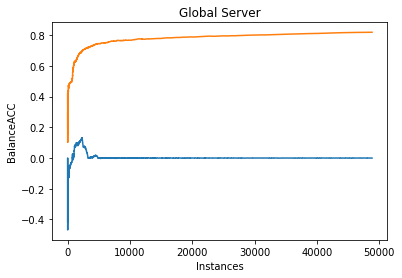

In [14]:
import matplotlib.pyplot as plt
plt.plot(stp_list)
plt.title('Global Server')
plt.xlabel('Instances')
plt.ylabel('BalanceACC')
plt.plot(bal_acc_list)

In [11]:
print(bal_acc_list)

[0.2916666666666667, 0.2727272727272727, 0.265625, 0.2619047619047619, 0.25961538461538464, 0.46794871794871795, 0.46639784946236557, 0.46527777777777773, 0.4644308943089431, 0.463768115942029, 0.463235294117647, 0.462797619047619, 0.462431693989071, 0.4621212121212121, 0.481060606060606, 0.4807938540332906, 0.48056220095693775, 0.4876644736842105, 0.48746141975308643, 0.48728197674418605, 0.48712225274725274, 0.4908424908424909, 0.4906994047619048, 0.39683493589743596, 0.4214584920030465, 0.4201741654571844, 0.4190055440055441, 0.43606509735542, 0.43499721913236933, 0.4340175953079179, 0.4463383838383838, 0.4454365079365079, 0.4636874469889737, 0.4805964052287582, 0.4289365136298422, 0.4269157585192873, 0.4421566989642499, 0.45638830560491034, 0.41595882522315003, 0.4324763017789897, 0.44579562594268474, 0.45828766289124345, 0.454966926529648, 0.4518403852769177, 0.46309603386809267, 0.4737298234210811, 0.47035104364326374, 0.4671491633302535, 0.43607423335826473, 0.4457908163265306, 

In [10]:
print(stp_list)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.41666666666666663, 0.41666666666666663, 0.41666666666666663, 0.41666666666666663, 0.41666666666666663, 0.41666666666666663, 0.41666666666666663, 0.41666666666666663, 0.41666666666666663, 0.0, 0.0, 0.0, 0.037878787878787845, 0.037878787878787845, 0.037878787878787845, 0.037878787878787845, 0.05208333333333337, 0.05208333333333337, -0.1785714285714285, -0.1785714285714285, -0.1785714285714285, -0.1785714285714285, -0.12820512820512808, -0.12820512820512808, -0.12820512820512808, -0.09408602150537626, -0.09408602150537626, -0.09408602150537626, -0.09408602150537626, -0.20833333333333326, -0.20833333333333326, -0.20833333333333326, -0.20833333333333326, -0.2947154471544715, -0.33259423503325936, -0.33259423503325936, -0.33259423503325936, -0.33259423503325936, -0.33259423503325936, -0.33259423503325936, -0.33259423503325936, -0.33259423503325936, -0.33259423503325936, -0.40019762845849793, -0.40019762845849793, -0.40019762845849793, -0.40019762845849793, -0.4545

In [17]:
print(len(bal_acc_list))

48842
